# Analysis of Ad-Hoc Communications Network

You have been asked to help with planning an ad-hoc communications network over a large rectangular region. Each individual tower can monitor a rectangular subsection of a specific width and height. The main problem is that none of the individual towers can provide coverage for the entire region of interest. Communications towers are unreliable and are put up independently and at random. You have no control over where or how big a tower’s footprint is placed. Importantly, due to technical issues such as cross-talk, no individual rectangular subsection can have multiple towers providing coverage for it. That is, there can be no overlap between any pair of rectangular subsections provided by the two respective towers. In any case, the desire is to maximize the coverage area of any available
communications tower

The order of when the towers come online is important. Once a tower has acquired its rectangular section, no subsequent tower can overlap that section. You may assume the following for this problem:  
1. All rectangular sections have integer-based corners.  
2. All rectangular sections must be contained in the overall rectangular footprint.  
3. The height and width of each rectangular section is sampled from a uniform  distribution.  
4. Positions of the windows are also determined by uniform random distribution.  
5. All footprints must be rectangles (not general polygons).  
6. When a new tower comes online, if its coverage rectangle intersects the pre-existing composite footprint, then that new tower’s coverage is trimmed such that its maximum remaining coverage area is retained (see sequential diagram below).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import colors as mcolors

## Class Network  
In this project, I will create two classes. One is Network, on which all the towers would be placed. The other is Tower object.

Within Network, I have functions to build specified valued towers(in order to test specified cases) and random valued towers.

In [2]:
class Network():
    def __init__(self, w, h):
        """
        :@param w: int, width of this network(desired coverage)
        :@param h: int, height of this network(desired coverage)
        """
        assert(isinstance(w, int))
        assert(isinstance(h, int))
        assert(w > 0 and h > 0)
        self.towers = []    # list to store the current tower objects
        self.width = w
        self.height = h
        self.board = np.zeros((h + 1, w + 1))
    
    def buildNTowers(self, n):
        """
        Continuously build n random towers at once
        :@param n: int, the number of towers to build
        """
        assert(isinstance(n, int))
        assert(n > 0)
        for i in range(n):
            self.buildTower()
    
    def buildTower(self):
        """
        Build one random tower
        """
        t = Tower(self)
        self.towers.append(t)
        self.showTowers()
        if bestTrim(self.towers[-1], self.towers[:-1]):
            if self.towers[-1].w == 0 and self.towers[-1].h == 0: # if the tower is completely trimmed out, remove it
                self.towers = self.towers[:-1]
            self.showTowers()
    
    def buildTowerNotShow(self):
        """
        Build one random tower without visualization
        """
        t = Tower(self)
        self.towers.append(t)
        bestTrim(self.towers[-1], self.towers[:-1])
        if self.towers[-1].w == 0 and self.towers[-1].h == 0: # if the tower is completely trimmed out, remove it
            self.towers = self.towers[:-1]
        
    def buildSpecialTower(self, x, y, w, h):
        """
        Build only one tower with specified infos
        :@param x: int, specified x position of the bottom-left corner
        :@param y: int, specified y position of the bottom-left corner
        :@param w: int, specified width of this tower
        :@param h: int, specified height of this tower
        """
        assert(isinstance(x, int))
        assert(isinstance(y, int))
        assert(isinstance(w, int))
        assert(isinstance(h, int))
        assert(x >= 0 and x < self.width)
        assert(y >= 0 and y < self.height)
        assert(w > 0 and w <= self.width - x)
        assert(h > 0 and h <= self.height - y)
        t = Tower(self)
        t.setInfo(x, y, w, h)
        self.towers.append(t)
        self.showTowers()
        if bestTrim(self.towers[-1], self.towers[:-1]):
            if self.towers[-1].w == 0 and self.towers[-1].h == 0: # if the tower is completely trimmed out, remove it
                self.towers = self.towers[:-1]
            self.showTowers()
        
        
    def showTowers(self):
        """
        Visualize the current network
        """
        colors = ["red", "green", "yellow", "brown", "blue", "skyblue", "purple", "pink", "gray", "lime", "gold", "orange", "olive", "cyan"]
        
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect='equal')
        plt.ylim(0, self.height)
        plt.xlim(0, self.width)
        for i, t in enumerate(self.towers):
            ax.add_patch(Rectangle(t.pos, t.w, t.h, color=colors[i], linewidth=2, alpha=0.5))
            if t.w and t.h:
                ax.annotate("%d" %i, (t.x + t.w / 2, t.y + t.h / 2), color='b', weight='bold', fontsize=10, ha='center', va='center')
        plt.show()
    
    def coveredArea(self):
        areas = 0
        for t in self.towers:
            areas += t.w * t.h
        return areas

    def isFullCovered(self):
        return self.coveredArea() == (self.width * self.height)

## Class Tower  
The initializer will randomly pick values for the bottom-left corner, the width of the tower and the height of the tower.  
We will also have a function to manually set up the values(as mentioned before, we use it to test specified cases).

In [3]:
import random

class Tower():
    def __init__(self, net):
        """
        Initializer of class Tower
        Randomly set the bottom-left corner position, width and height
        :@param net: the network that this tower object is on
        """
        self.network = net
        # width
        self.w = random.randint(1, self.network.width)
        # height
        self.h = random.randint(1, self.network.height)
        # the bottom-left corner of this tower
        self.x = random.randint(0, self.network.width - self.w)
        self.y = random.randint(0, self.network.height - self.h)
        self.pos = (self.x, self.y)

    
    def setInfo(self, x, y, w, h):
        """
        Manually set the info of this tower
        :@param x: int, x value of the bottom-left corner
        :@param y: int, y value of the bottom-left corner
        :@param w: int, width
        :@param h: int, height
        """
        self.x, self.y = x, y
        self.w, self.h = w, h
        self.pos = (x, y)
    
    def info(self):
        """
        show the info of the tower
        """
        return (self.w, self.h, self.pos)

## Overlap  
To reach the functionality of trimming overlapped area while maximizing possible remaining area, we first want to check whether two towers are overlapped with each other.  
This part is relative easy due to the rectangle constraints of all towers.  
With this constraint, we can conclude that there are in total 4 cases of "non-overlap":    
1. t1 is completely to the left of t2
2. t1 is completely to the right of t2
3. t1 is completely to the above of t2
4. t1 is completely to the bottom of t2  

We can translate these 4 cases into numerical conditions as shown in the follwing function.

In [4]:
def isOverlap(t1, t2):
    """
    Detect if t1 is overlapped with t2
    :@param t1: Tower, tower 1
    :@param t2: Tower, tower 2
    :@return: bool, boolean value of whether t1 and t2 are overlapped
    """
    if t1.x + t1.w < t2.x or t1.x > t2.x + t2.w or t1.y + t1.h < t2.y or t2.y + t2.h < t1.y:
        return False
    else:
        return True

## Trim  
This is the tricky part of this project. Rather than stretching the rectangle in diagonal directions all at once(I have tried this way before but failed), I chose to trim my new tower step-by-step.  
This means that, I want to trim my new tower with respect to each single of previous towers.  
Now, since we are only consider 2 towers at a time, there are only 4 cases left for the possible trimming:  
1. Going up
2. Going down
3. Going right
4. Going left

Then regarding these 4 cases, we select the one with the maximum remaining area. Then based on the strategy we chose, we update the bottom-left corner, the width and the height of the tower to be trimmed.  

This is a greedy strategy that given a specified order of trimming, we always choose the best order. **However**, the problem is, there are such cases that this greedy algorithm is **not always correct**(I will talk about it using an example in the next section).  

Thus to overcome this difficulty, I chose to exhaustively search for the best strategy(order) to trim my new tower:
1. Generate a permutation list of existed towers
2. Based on each order of towers, trim the new tower and get the resulting area
3. Choose the strategy which gives the maximum resulting area  

The code function is shown below. **trim(t1, t2)** trims t1 with respect to t2. **bestTrim(t, towers)** trims t by choosing the best strategy to trim.

In [5]:
import itertools
import copy

def trim(t1, t2):
    """
    Trim t1 with respect to t2 and maximize the possible remaining area if they are overlapped
    :@param t1: Tower, tower 1, the tower to be trimmed
    :@param t2: Tower, tower 2
    :@return: tuple: (t1.x, t1.y, t1.w, t1.h, max area), a tuple storing information
    """
    if t1.x >= t2.x and t1.x + t1.w <= t2.x + t2.w and t1.y >= t2.y and t1.y + t1.h <= t2.y + t2.h:
        t1.w, t1.h = 0, 0
        t1.x, t1.y = 0, 0
    if isOverlap(t1, t2):
        
        # There are four directions that we can trim t1
        # Now we want to find all of them are find the best strategy
        areaUp = (t2.y - t1.y) * t1.w
        areaDown = (t1.y + t1.h - t2.y - t2.h) * t1.w
        areaRight = (t2.x - t1.x) * t1.h
        areaLeft = (t1.x + t1.w - t2.x - t2.w) * t1.h
        areas = [areaUp, areaDown, areaRight, areaLeft]
        best = float('-inf')
        bestArea = float('-inf')
        for i, a in enumerate(areas):
            if a > bestArea:
                bestArea = a
                best = i
#         best = np.argmax(areas)
        # Choose the best strategy and update tower's info
        if best == 0:
            # going up
            t1.h = t2.y - t1.y
        elif best == 1:
            # going down
            t1.h = t1.y + t1.h - t2.y - t2.h
            t1.y = t2.y + t2.h
            t1.pos = (t1.x, t1.y)
        elif best == 2:
            # going right
            t1.w = t2.x - t1.x
        else:
            # going left
            t1.w = t1.x + t1.w - t2.x- t2.w
            t1.x = t2.x + t2.w
            t1.pos = (t1.x, t1.y)
        return (t1.x, t1.y, t1.w, t1.h, areas[best])
    else:
        return (t1.x, t1.y, t1.w, t1.h, t1.w * t1.h)

def bestTrim(t, towers):
    """
    Get the best trim strategy of trimming orders
    :@param t: Tower, the tower to be trimmed
    :@param towers: list of Tower, a list of previous existed towers that t will be trimmed on
    :@return: bool, boolean value of whether t1 is trimmed
    """
    strategies = list(itertools.permutations(towers))
    best = (t.x, t.y, t.w, t.h)
    if strategies != [()]:
        candidates = []
        for s in strategies:
            t1 = copy.copy(t)
            for t2 in s:
                result = trim(t1, t2)
            candidates.append(result)
        best = max(candidates, key=lambda x: x[4])
    if t.x == best[0] and t.y == best[1] and t.w == best[2] and t.h == best[3]:
        return False
    else:
        t.x, t.y = best[0], best[1]
        t.w, t.h = best[2], best[3]
        t.pos = (t.x, t.y)
        return True

We can test the functionality of this function by following(Notice that **buildSpecialTower** allows us to build a tower with specified bottom-left corner position, width and height. See the doc string with the function for more detailed information).  
**You can change the values of the second tower coming in to test on different cases.**

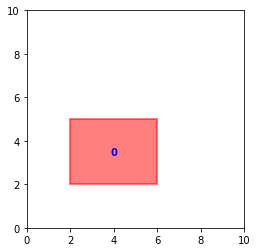

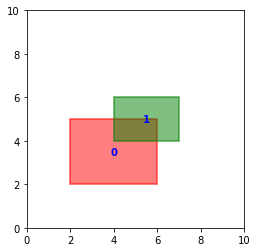

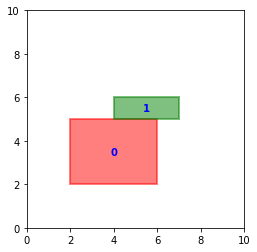

In [6]:
n = Network(10, 10)
n.buildSpecialTower(2, 2, 4, 3)
n.buildSpecialTower(4, 4, 3, 2)

## Wrap-up  
Now we have all the functionalities ready(for more information, please read the doc string within each function and each class). We can finally test the overall functionality and meet the requirements.

## Question 1  
**Given an overall desired coverage footprint and a sequence of n communications towers, what is the resulting resolved coverage?**  

For this question, the user specified the width and the height of the desired network and then pass in a list of tuples.  
Each tuple represents the info the user want with each tower in such format: **(x, y, width, height)**. Notice that here **x** and **y** are the coordinates of the bottom-left corner.  

Ex. (0, 2, 3, 4) means a tower of which the bottom-left corner is (0, 2) having width of 3 and height of 4.

In [7]:
# Question 1
def generateNetwork(w, h, towers):
    """
    Taking the desired size of overall coverage and a list of towers' settings
    Show the resolved coverage
    :@param w: int, desired width of the network
    :@param h: int, desired height of the network
    :@param towers: tuple, a list of tuples formatted as (x, y, width, height)
                    x and y are the position of the bottom-left corner
    """
    assert(isinstance(w, int))
    assert(isinstance(h, int))
    assert(w > 0 and h > 0)
    assert(isinstance(towers, list))
    
    myNet = Network(w, h)
    for t in towers:
        assert(isinstance(t, tuple))
        assert(isinstance(t[0], int) and isinstance(t[1], int) and isinstance(t[2], int) and isinstance(t[3], int))
        assert(len(t) == 4)
        myNet.buildSpecialTower(t[0], t[1], t[2], t[3])
    cArea = myNet.coveredArea()
    fraction = cArea * 100.0 / (w * h)
    print("The final resolved covered area is: %d" % cArea)
    print("Coverage fraction is: %.2f%%" % fraction)
    print("The gap is: %d" % (w * h - cArea))

### Test sample  
To test the functionality, we can borrow the sample from the project instructions.  
This function will visualize the whole process of building, trimming and the final resolved area and recovered fraction.

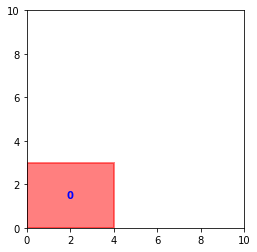

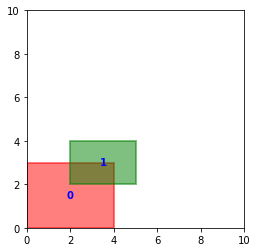

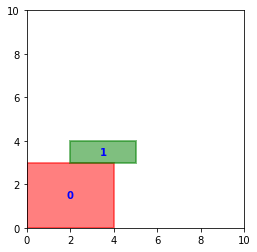

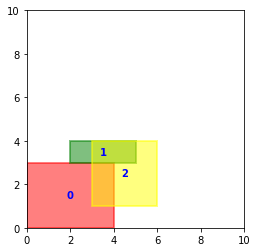

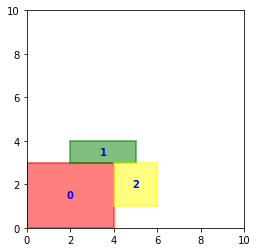

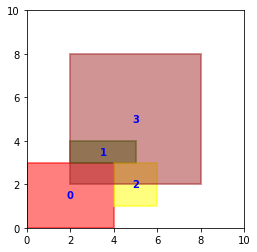

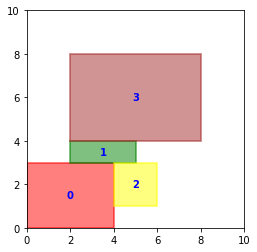

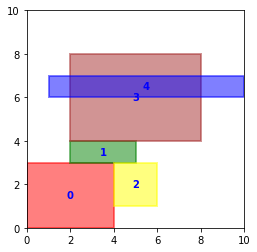

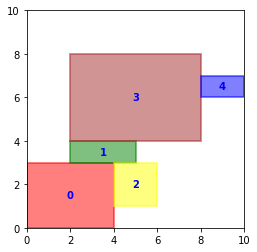

The final resolved covered area is: 45
Coverage fraction is: 45.00%
The gap is: 55


In [8]:
tester = [(0, 0, 4, 3), (2, 2, 3, 2), (3, 1, 3, 3), (2, 2, 6, 6), (1, 6, 9, 1)]
generateNetwork(10, 10, tester)

### Test sample(tricky)  
As I mentioned before, if we only trim our new tower following the order of existed towers, it could be a problem leading us to the wrong answer.  
We can see the following example(actually I generated this example by random and I found out why the previous algorithm did not work).  
Here in this example there is no problem at all until **tower 4** comes in.  
Though the visualization below shows the correct trimming, if we use the strategy to trim our new towers following the order of (0, 1, 2, 3), then we can easily find out that by doing that, tower 4 would vanish.  
This is because when we trim **tower 4** with respect to **tower 0**, it would be trimmed to the left half as you can easily tell. And then when it comes to the turn of **tower 2**, since now the remaining part of **tower 4** is completely included by **tower 2**, the algorithm chooses to destroy **tower 4**, which leads to a wrong answer.  

Thus, avoiding that kind of tricky situations, I used Brute Force search and will always find the best strategy to trim my new tower, as you can see in the following case.

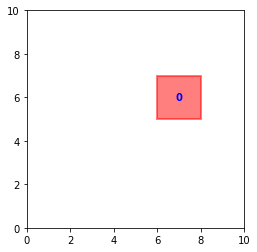

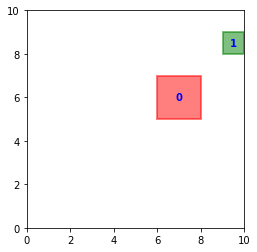

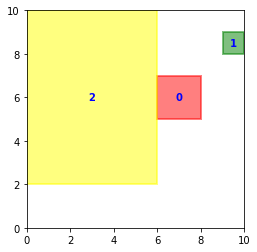

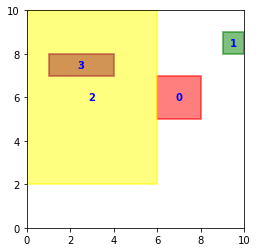

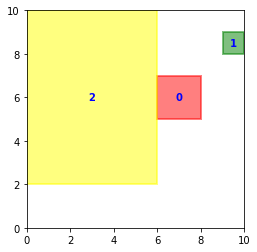

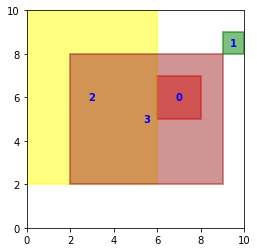

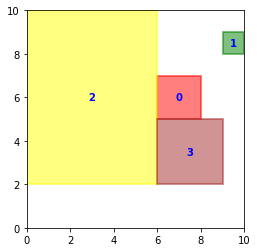

The final resolved covered area is: 62
Coverage fraction is: 62.00%
The gap is: 38


In [9]:
tester2 = [(6,5,2,2), (9,8,1,1), (0,2,6,8), (1,7,3,1), (2,2,7,6)]
generateNetwork(10, 10, tester2)

## Qustion 2  
**What is the total area of coverage relative to the desired total coverage area of the original footprint? That is, are there any gaps in coverage?**  

Now, instead of specified towers, we want to generate random towers since the original insights of this problem is that we cannot control where and how big the incoming towers are.  
Here the user need to specified the width, the height of the desired network and an integer **n**(how many towers to use). And the function will automatically build n towers randomly.

In [10]:
# Question 2
def generateRandomNetwork(w, h, n):
    """
    Taking the desired size of overall coverage and the number of towers to build
    Show the resolved coverage
    :@param w: int, desired width of the network
    :@param h: int, desired height of the network
    :@param n: int, the number of random towers to build
    """
    assert(isinstance(w, int))
    assert(isinstance(h, int))
    assert(isinstance(n, int))
    assert(w > 0 and h > 0 and n > 0)
    
    myNet = Network(w, h)
    for i in range(n):
        myNet.buildTower()
    cArea = myNet.coveredArea()
    fraction = cArea * 100.0 / (w * h)
    print("The final resolved covered area is: %d" % cArea)
    print("Coverage fraction is: %.2f%%" % fraction)
    print("The gap is: %d" % (w * h - cArea))

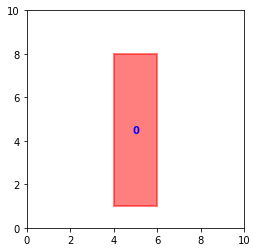

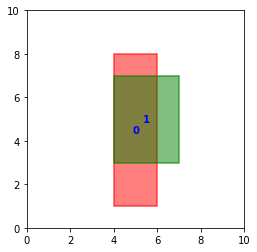

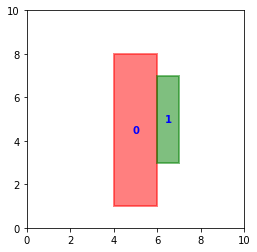

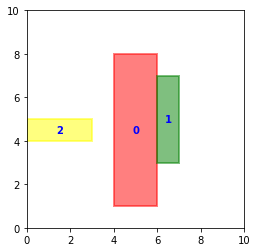

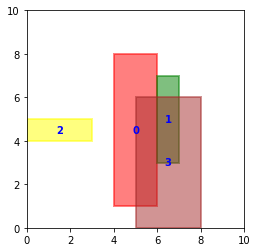

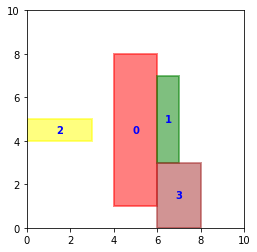

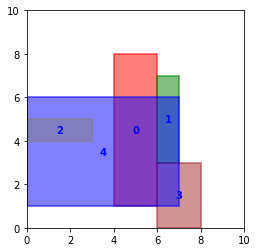

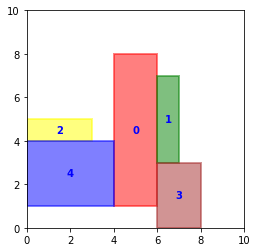

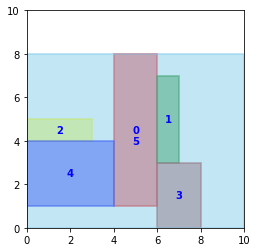

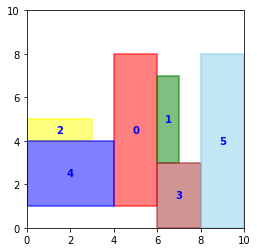

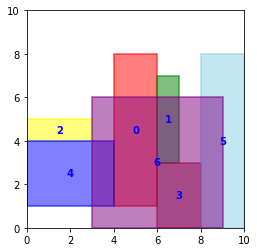

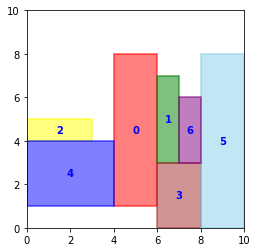

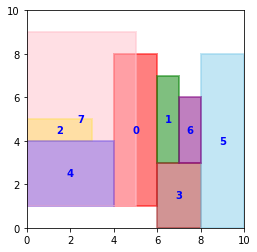

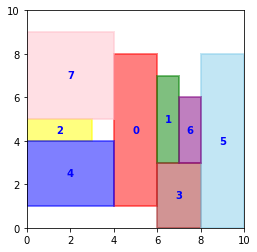

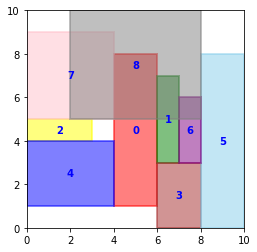

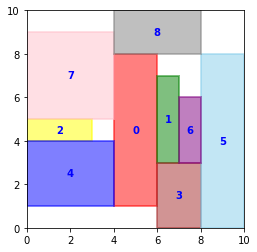

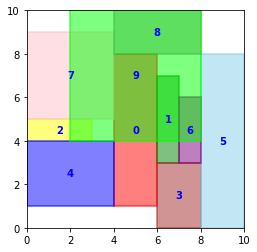

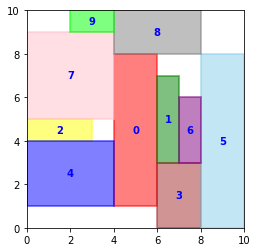

The final resolved covered area is: 84
Coverage fraction is: 84.00%
The gap is: 16


In [11]:
generateRandomNetwork(10, 10, 10)

## Question 3  
Now in this question, we want to compute the average number of towers needed to be built to get a full coverage for each pair of (width, height).  
To do this, I created functions **isFullCovered** to check whether the network is fully covered.  
In this problem, I have tested the average number of towers needed to generate a full coverage. **Note** that this result may vary and since I am using brute force search, as the the number of existing towers grows, the running time will grows as O(n!), which can take really long time.  
I suggest to limit w and h to below 5 to generate a reasonably fast answer.  

The result of average usage is shown in the heatmap.

In [12]:
import seaborn as sns

def findAverageFull(W, H, N):
    """
    Count the average number of towers needed to get a full coverage for different widths and heights
    :@param W: int, the upper bound of choice of w
    :@param H: int, the upper bound of choice of h
    :@param N: int, the number of runs specified to run on each pair of (w, h)
    """
    m = np.zeros((W, H))
    for w in range(1, W + 1):
        for h in range(1, H + 1):
            count = 0
            for i in range(N):
                n = Network(w, h)
                while not n.isFullCovered():
                    n.buildTowerNotShow()
                    count += 1
            m[w-1, h-1] = count / 5.0
    sns.set()
    ax = sns.heatmap(m)

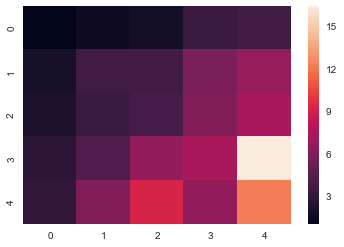

In [15]:
findAverageFull(5, 5, 5)